In [1]:
# # # Needed only for execution on Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Run only if missing packages
# import sys
# !pip install plotly==4.7.0
# !pip install arviz==0.7.0
# !pip install pymc3==3.8
# !pip install Theano==1.0.4
# !pip install numpy scipy pandas
# !pip install seaborn sklearn graphviz

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
def initialize_plt_font(latex=False):
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    import os
    fm = fm.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v310.json"))
    # specify the custom font to use
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = u'Helvetica'
    plt.style.use('seaborn-white')
    plt.rcParams['text.usetex'] = latex
#     plt.rcParams['font.family'] = 'sans-serif'
#     plt.rcParams['font.sans-serif'] = ['Helvetica']
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

In [5]:
import numpy as np
from scipy.stats import t as studentT
import pandas as pd
from theano import shared
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import math
import graphviz

from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rc
import arviz as az

from IPython.display import Image

initialize_plt_font()
color = '#87ceeb'
print('Running on PyMC3 v{}'.format(pm.__version__))

# If it is run on Colab, put the exp3 folder in the root of your Google drive and use this data path
# DATA_PATH = "drive/My Drive/exp3"
# If it is run on a local machine, use the following data path
DATA_PATH = "exp2_data"

Running on PyMC3 v3.8


##Data Import

In [6]:
all_data = pd.read_csv(DATA_PATH + '/Experiment2_final_data.csv')
all_data.head()

,userId,complete,time,group,path,gender,age,origin,ethnicity,occupation,...,reasonArray.MS,reasonArray.AQ,reasonArray.VR,reasonArray.AS,reasonArray.AVS,priceArray.AQ,priceArray.VR,priceArray.AS,priceArray.MS,priceArray.AVS
0,5f819a30b9ef559055a0fedb,True,2020-10-10T11:48:55.672Z,gp11,p1,(a) Male,(c) 40-54,(b) No,(e) White,(q) Other (Please specify in next question),...,"Not massively important, but still will need m...","This is going to use a lot of bandwidth, but n...","This is going to eat up the most bandwidth, so...","Like audio quality, if you can't understand, i...","For such a streaming service, this is not huge...",1.00,3.00,0.35,0.70,0.0
1,5f78f70b2332c99521a8b810,True,2020-10-03T23:03:55.031Z,gp11,p2,(b) Female,(c) 40-54,(b) No,(e) White,(q) Other (Please specify in next question),...,The motion smoothness is worth a small percent...,"This component is worth the cost, it brings th...",This component is worth the cost. It's a quali...,The audio quality is a minor adjustment,I feel the audio video video synchronization a...,4.00,4.00,1.00,1.00,0.0
2,5f819e26b9ef559055a0fee3,True,2020-10-10T12:22:35.488Z,gp14,p2,(a) Male,(d) 55 or above,(b) No,(b) Asian,"(l) Service (e.g., retail clerks, server)",...,The visual is not as much important as the sou...,The sound is important.,The visual is not as much important as the sou...,The sound is important.,It is not as important.,2.00,0.50,2.00,0.50,0.0
3,5f78ac66108ffa4e7e701057,True,2020-10-03T17:34:48.174Z,gp16,p2,(b) Female,(d) 55 or above,(b) No,(e) White,"(a) Administrative support (e.g., secretary, a...",...,It's less important to getting the information...,It's the most important element.,"This is crucial, too",This is also absolutely necessary to understan...,"I left this at the base level, which is so bad...",1.59,1.09,1.51,0.81,0.0
4,5f80aa38b9ef559055a0fe3f,True,2020-10-09T18:56:43.191Z,gp3,p2,(b) Female,(a) 18-24,(b) No,(e) White,(n) Student,...,Motion Smoothness did not create a big enough ...,Audio quality was the biggest contributor to m...,Being able to see the numbers and cities on th...,Audio Stability increased my understanding of ...,"As I watched the video, I found no change in m...",2.50,1.00,2.00,0.00,0.0


In [7]:
likert_columns = ['likert.audio_quality', 'likert.video_resolution', 'likert.audio_stability', 'likert.video_smoothness', 'likert.sync']
likert_np = all_data[likert_columns].to_numpy() - 3
print(likert_np.shape)

(93, 5)


In [8]:
qv_columns = [' AQ', ' VR', ' AS', ' MS', ' AVS']
qv_np = all_data[qv_columns].to_numpy()
print(qv_np[:10,])

[[ 8  4  3  3  1]
 [ 6  6  3  3  3]
 [ 6  3  6  3  3]
 [ 6  5  6  1  1]
 [ 7  3  6  2  1]
 [ 7  5  4  1  3]
 [ 5  4  6  2  4]
 [ 7  6  2  3 -1]
 [ 8  1  5  3  1]
 [ 6  6  4  3  1]]


In [9]:
price_columns = ['priceArray.AQ', 'priceArray.VR', 'priceArray.AS', 'priceArray.MS', 'priceArray.AVS']
price_np = all_data[price_columns].to_numpy()
print(price_np.shape)

(93, 5)


## Descriptive Statistics

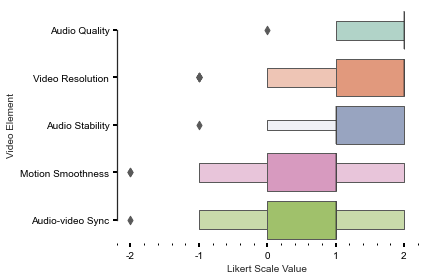

In [10]:
# Plot and compare vote distribution across elements for likert
g = sns.boxenplot(
    data=likert_np,
    palette="Set2",
    orient='h',
    linewidth=0.1,
    saturation=0.65)

g.set_xticklabels(range(-2, 3, 1))
g.set_yticklabels(['Audio Quality', 'Video Resolution', 'Audio Stability', 
                   'Motion Smoothness', 'Audio-video Sync'])
g.set_xlabel('Likert Scale Value')
g.set_ylabel('Video Element')

# custom limits requires us to tell where the majot and minor ticks are
majorLocator = MultipleLocator(1) 
minorLocator = MultipleLocator(0.2)

g.xaxis.set_major_locator(majorLocator)
g.xaxis.set_minor_locator(minorLocator)

g.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.tick_params(
    direction='out', length=2, width=1, colors='k', which='minor', left=False)
g.minorticks_on()
sns.despine(ax=g, left=False, bottom=True, trim=True)

# fig = g.get_figure()
plt.tight_layout()
plt.savefig(DATA_PATH + "/likert_distribution_per_element.pdf")

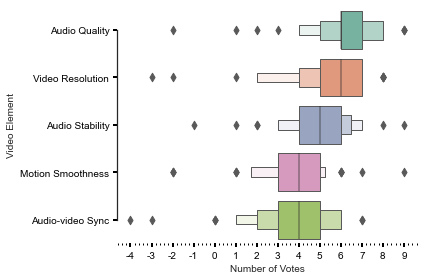

In [11]:
# Plot and compare vote distribution across elements for QV
g = sns.boxenplot(
    data=qv_np,
    palette="Set2",
    orient='h',
    linewidth=0.1,
    saturation=0.65)

g.set_xticklabels(range(-4, 16, 1))
g.set_yticklabels(['Audio Quality', 'Video Resolution', 'Audio Stability', 
                   'Motion Smoothness', 'Audio-video Sync'])
g.set_xlabel('Number of Votes')
g.set_ylabel('Video Element')

# custom limits requires us to tell where the majot and minor ticks are
majorLocator = MultipleLocator(1) 
minorLocator = MultipleLocator(0.2)

g.xaxis.set_major_locator(majorLocator)
g.xaxis.set_minor_locator(minorLocator)

g.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.tick_params(
    direction='out', length=2, width=1, colors='k', which='minor', left=False)
g.minorticks_on()
sns.despine(ax=g, left=False, bottom=True, trim=True)

plt.tight_layout()
plt.savefig(DATA_PATH + "/qv_distribution_per_element.pdf")

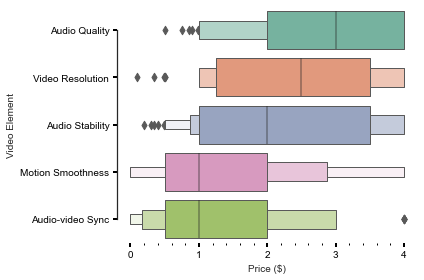

In [12]:
# Plot and compare price distribution across elements for pricing
g = sns.boxenplot(
    data=price_np,
    palette="Set2",
    orient='h',
    linewidth=0.1,
    saturation=0.65)

g.set_xticklabels(range(0, 5, 1))
g.set_yticklabels(['Audio Quality', 'Video Resolution', 'Audio Stability', 
                   'Motion Smoothness', 'Audio-video Sync'])
g.set_xlabel('Price ($)')
g.set_ylabel('Video Element')

# custom limits requires us to tell where the majot and minor ticks are
majorLocator = MultipleLocator(1) 
minorLocator = MultipleLocator(0.2)

g.xaxis.set_major_locator(majorLocator)
g.xaxis.set_minor_locator(minorLocator)

g.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.tick_params(
    direction='out', length=2, width=1, colors='k', which='minor', left=False)
g.minorticks_on()
sns.despine(ax=g, left=False, bottom=True, trim=True)

plt.tight_layout()
plt.savefig(DATA_PATH + "/price_distribution_per_element.pdf")

### Covariates of votes and price

In [13]:
def add_id_column(df):
  l = df.shape[0]
  id_col = pd.DataFrame(range(l), columns=['ID'])
  df_ind = pd.concat([id_col, df], axis=1)
  return df_ind

In [14]:
# Add "category" column to a df
def df_add_category(data, group, cols):
  l = data.shape[0]
  condition = pd.DataFrame([group] * l, columns=['condition'])
  cond_df = pd.concat([data, condition], axis=1)
  return cond_df

In [15]:
same_columns = ['Audio Quality', 'Video Resolution', 'Audio Stability', 
                   'Motion Smoothness', 'Audio-video Sync']

In [16]:
price_np_norm = price_np/4
price_df_norm = pd.DataFrame(price_np_norm, columns=same_columns)
price_ind = add_id_column(price_df_norm)
price_melt = pd.melt(price_ind, id_vars=['ID'], value_vars=same_columns,
        var_name='element', value_name='price')
price_melt.head()

,ID,element,price
0,0,Audio Quality,0.2500
1,1,Audio Quality,1.0000
2,2,Audio Quality,0.5000
3,3,Audio Quality,0.3975
4,4,Audio Quality,0.6250


In [17]:
likert_np_norm = likert_np / 2
likert_df_norm = pd.DataFrame(likert_np_norm, columns=same_columns)
likert_ind = add_id_column(likert_df_norm)
likert_melt = pd.melt(likert_ind, id_vars=['ID'], value_vars=same_columns,
        var_name='element', value_name='vote')
likert_melt_df = df_add_category(likert_melt, 'likert', ["ID"] + same_columns)
likert_melt_df.head()

,ID,element,vote,condition
0,0,Audio Quality,1.0,likert
1,1,Audio Quality,1.0,likert
2,2,Audio Quality,1.0,likert
3,3,Audio Quality,1.0,likert
4,4,Audio Quality,1.0,likert


In [18]:
qv_np_norm = qv_np / 10
qv_df_norm = pd.DataFrame(qv_np_norm, columns=same_columns)
qv_ind = add_id_column(qv_df_norm)
qv_melt = pd.melt(qv_ind, id_vars=['ID'], value_vars=same_columns,
        var_name='element', value_name='vote')
qv_melt_df = df_add_category(qv_melt, 'qv', ["ID"] + same_columns)
qv_melt_df.head()

,ID,element,vote,condition
0,0,Audio Quality,0.8,qv
1,1,Audio Quality,0.6,qv
2,2,Audio Quality,0.6,qv
3,3,Audio Quality,0.6,qv
4,4,Audio Quality,0.7,qv


In [19]:
# Combine votes and prices into one DF
likert_melt_vp = pd.concat([likert_melt_df, price_melt['price']], axis=1)
qv_melt_vp = pd.concat([qv_melt_df, price_melt['price']], axis=1)

# Combine different conditions into one DF
all_melt_vp = pd.concat([likert_melt_vp, qv_melt_vp], axis=0)
print(all_melt_vp.shape)
all_melt_vp.head()

(930, 5)


,ID,element,vote,condition,price
0,0,Audio Quality,1.0,likert,0.2500
1,1,Audio Quality,1.0,likert,1.0000
2,2,Audio Quality,1.0,likert,0.5000
3,3,Audio Quality,1.0,likert,0.3975
4,4,Audio Quality,1.0,likert,0.6250


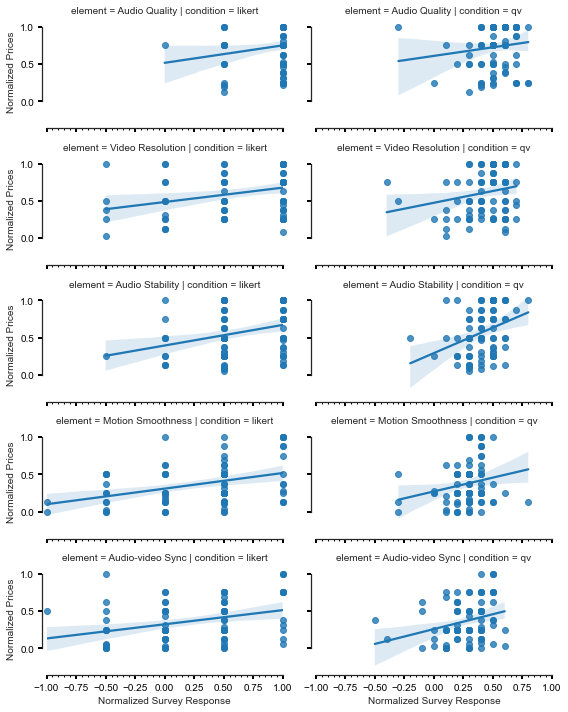

In [60]:
# Covariates between votes and prices
g = sns.lmplot(
    data=all_melt_vp,
    height=2,
    scatter_kws={'clip_on':False},
    x='vote',
    y='price',
    row='element',
    col='condition',
    palette="Set2",
    aspect=2).set_axis_labels(
       "Normalized Survey Response", "Normalized Prices")

# custom limits requires us to tell where the majot and minor ticks are
# majorLocator = MultipleLocator(1) 
# minorLocator = MultipleLocator(0.2)

# g.ax.xaxis.set_major_locator(majorLocator)
# g.ax.xaxis.set_minor_locator(minorLocator)

# g.ax.tick_params(direction='out', length=4, width=2, colors='k', which='major')
# g.ax.tick_params(
#     direction='out', length=2, width=1, colors='k', which='minor', left=False)
# g.ax.minorticks_on()

for i in range(5):
    for j in range(2):
        g.axes[i,j].set(xticks=np.arange(-1, 1.1, 0.25), clip_on=False)
        g.axes[i,j].tick_params(direction='out', length=4, width=2, colors='k', which='major')
        g.axes[i,j].tick_params(
            direction='out', length=2, width=1, colors='k', which='minor', left=False)
        g.axes[i,j].minorticks_on()

g.despine(offset=5, left=False, bottom=False, trim=True)
plt.tight_layout()
plt.savefig(DATA_PATH + "/correlation_per_element.pdf")

In [21]:
# calculate number of credits on each option in qv
qv_sign = np.sign(qv_np)
qv_credit = np.multiply(qv_sign, np.square(qv_np))
qv_credit_total = np.sum(qv_credit, axis=1)
qv_credit_use = qv_credit_total / 100
print(np.median(qv_credit_use))
print(np.sum(qv_credit_use>=0.98))

0.98
53


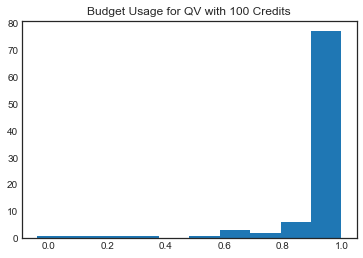

In [22]:
plt.hist(qv_credit_use)
plt.title('Budget Usage for QV with 100 Credits')
plt.show()

## Alignment Analysis on an Individual Level Using Similarity Angle Theta

In [23]:
# concatenate votes and price into one numpy array
likert_price = np.concatenate((likert_np, price_np), axis=1)
qv_price = np.concatenate((qv_np, price_np), axis=1)
# likert_price = np.concatenate((likert_np, price_np), axis=1)
# qv_price = np.concatenate((qv_credit, price_np), axis=1)
print(likert_price.shape)
print(qv_price.shape)

(93, 10)
(93, 10)


In [24]:
def cosine_sim_theta(vd_np, dim):
    nr, _ = vd_np.shape
    thetas = []
    for i in range(nr):
        cos_sim = np.inner(vd_np[i, :dim], vd_np[i, dim:]) / (np.linalg.norm(vd_np[i, :dim]) * np.linalg.norm(vd_np[i, dim:]))
        # theta = math.acos(cos_sim)
        theta = math.acos(cos_sim) / math.pi * 180
        thetas.append(theta)

    return thetas

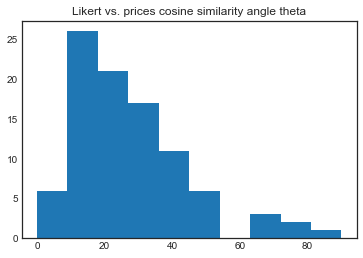

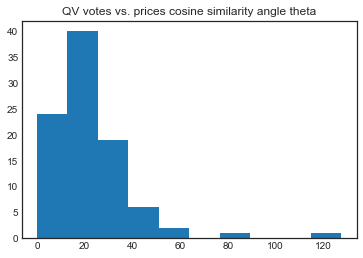

In [25]:
# calculate thetas
likert_thetas = cosine_sim_theta(likert_price, 5)
qv_thetas = cosine_sim_theta(qv_price, 5)
plt.hist(likert_thetas)
plt.title('Likert vs. prices cosine similarity angle theta')
plt.show()
plt.hist(qv_thetas)
plt.title('QV votes vs. prices cosine similarity angle theta')
plt.show()

In [26]:
# normalized to 0 and 1 for each participant
def normalized_z_score(row_array):
  minimum = min(row_array)
  maximum = max(row_array)
  row_array_norm = (row_array - minimum) / (maximum - minimum)
  return row_array_norm

price_np_norm_z = np.apply_along_axis(normalized_z_score, 1, price_np)
print(price_np_norm[:5,])

[[0.25   0.75   0.0875 0.175  0.    ]
 [1.     1.     0.25   0.25   0.    ]
 [0.5    0.125  0.5    0.125  0.    ]
 [0.3975 0.2725 0.3775 0.2025 0.    ]
 [0.625  0.25   0.5    0.     0.    ]]


In [27]:
# concatenate non-negative votes and price into one numpy array
likert_price_pos = np.concatenate((likert_np_norm, price_np_norm), axis=1)
qv_price_pos = np.concatenate((qv_np_norm, price_np_norm), axis=1)
print(likert_price_pos.shape)
print(qv_price_pos.shape)

(93, 10)
(93, 10)


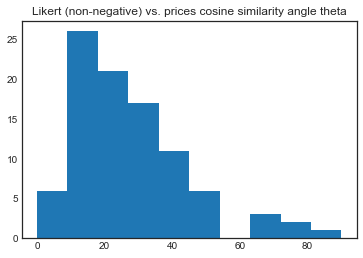

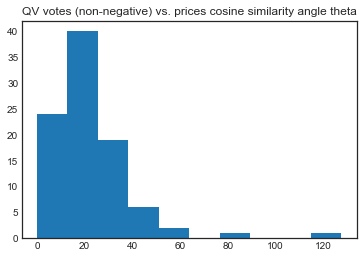

In [28]:
# calculate thetas for non-negative votes
likert_thetas_pos = cosine_sim_theta(likert_price_pos, 5)
qv_thetas_pos = cosine_sim_theta(qv_price_pos, 5)
plt.hist(likert_thetas_pos)
plt.title('Likert (non-negative) vs. prices cosine similarity angle theta')
plt.show()
plt.hist(qv_thetas_pos)
plt.title('QV votes (non-negative) vs. prices cosine similarity angle theta')
plt.show()

## Helper Functions for Bayesian

In [29]:
# add "category" column for thetas dataset
def df_add_category(thetas, group):
    l = len(thetas)
    condition = [group] * l
    thetas_array = {'thetas':thetas,'condition':condition}
    thetas_df = pd.DataFrame(thetas_array)
    return thetas_df

In [30]:
# Helper function from https://github.com/JWarmenhoven/DBDA-python
# Calculate Gamma shape and rate from mode and sd.
# if using gamma prior for the class dependent sigma

def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt(mode**2 + 4 * sd**2)) / (2 * sd**2)
    shape = 1 + mode * rate
    return (shape, rate)

In [31]:
def studentT_alignment_nd_indep(all_df):
    x = all_df.condition.cat.codes.values
    y = all_df.thetas
    # missing = y.isnull()
    # print(y[missing])

    # 0 - likert, 1 - QV

    yMean = y.mean()
    ySD = y.std()
    NxLvl = len(all_df.condition.cat.categories)

    aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)
    normalSigma = ySD * 100

    with pm.Model() as studentT_theta:
        mu = pm.Normal('mu', mu=yMean, sd=normalSigma, shape=NxLvl)

        ySigma = pm.Gamma('sigma', alpha=2, beta=0.1, shape=NxLvl)

        nu_minus1 = pm.Exponential('nu_minus1', 1/29.)
        nu = pm.Deterministic('nu', nu_minus1+1)
        studentT = pm.StudentT('y', nu=nu, mu=mu[x], sd=ySigma[x], observed=y)

        start = pm.find_MAP()
        trace_thetas = pm.sample(4000, tune=6000, start=start)

    return trace_thetas, studentT_theta

In [32]:
# varnames is a list of variable names as defined in the model trace
# title_names is a list of variable names in latex format that you want to display
def my_traceplots(varnames, title_names, trace, model_name):
    initialize_plt_font(latex=False)
    NRows = len(varnames) # variables to show
    NCols = 2
    fig, axs = sns.mpl.pyplot.subplots(NRows, NCols)

    fig.set_size_inches(NCols*9, NRows*2)


    pm.traceplot(trace, 
              varnames=varnames, 
              combined=True,
              ax=axs);


    for i in range(NRows):
        for j in range(NCols):
            z = axs[i, j]
            z.set_xlabel("") # no individual labels
            z.set_ylabel("")
            z.spines['right'].set_visible(False)
            z.spines['top'].set_visible(False)
            z.spines['left'].set_visible(False)
            z.spines['bottom'].set_visible(False)
            z.spines['bottom'].set_position(('outward', 10))
            z.yaxis.set_visible(True)
            z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
            z.tick_params(direction='in', length=4, width=1, colors='gray', which='minor')
            z.minorticks_on()

      # # axs[3,0].set_xscale('log')
      # # axs[3,1].set_yscale('log')

    for i in range(NRows):
      # axs[i,0].set_title(r('$' + title_names[i] + '$'), size=16)
      # axs[i,1].set_title(r('$' + title_names[i] + '$'), size=16)
        axs[i,0].set_title(title_names[i], size=18)
        axs[i,1].set_title(title_names[i], size=18)

    plt.subplots_adjust(hspace=1,
                          wspace=0.1)
    fig.tight_layout()
    fig.savefig(DATA_PATH + "/" + model_name + '_traceplot.pdf')

In [33]:
# helper function from https://github.com/JWarmenhoven/DBDA-python
def plot_mustache_studentT(var, sd, j, degree_f, axis, col, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var) * .05)):
        rv = studentT(loc=var[i], scale=sd[i], df=degree_f[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)

        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange * (width / xrange.max())

        # Using the negative value to flip the mustache in the right direction.
        axis.plot(-xrange_scaled + j, yrange, color=col, alpha=.6)

In [34]:
def pred_posterior_plot(trace, df, title, col):
    # Here we plot the metric predicted variable for each group. Then we superimpose the
    # posterior predictive distribution

    # In the trace, mean has the name "mu", std has the name 'sigma', and degree of freedom has the name 'nu'
    # In the df (observed data), values have the column name "thetas", and group category has the column name "condition"

    likert_post = trace['mu'][:, 0]
    qv_post = trace['mu'][:, 1]
    scale = trace['sigma'][:]
    d_f = trace['nu']

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.set_title(title + ' Data with Posterior Predictive Distribution')

    sns.swarmplot(
        'condition',
        'thetas',
        data=df,
        order=["likert","qv"],
    #     color="white",
    #     edgecolor="gray",
        ax=ax)
    ax.set_xlim(xmin=-1)

    for i, grp in enumerate([likert_post, qv_post]):
        sd = trace['sigma'][:,i]
        # plotting mustaches with the student t; the original function uses a normal dist
        plot_mustache_studentT(var=grp, sd=sd, j=i, degree_f=d_f, axis=ax, col=col, width=0.65)

    z = ax
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(
        direction='in', length=4, width=1, colors='k', which='minor', bottom=False)
    z.yaxis.set_ticks_position('left')
    z.spines['right'].set_visible(False)
    z.spines['top'].set_visible(False)
    z.spines['left'].set_visible(False)
    z.spines['bottom'].set_visible(False)
    z.spines['bottom'].set_position(('outward', 10))

    z.minorticks_on()

    fig.tight_layout()
    fig.savefig(DATA_PATH + "/" + title + " data, with StudentT posterior predictions.pdf")
    fig.show()

In [35]:
def plot_effect_size_dist(trace, title, col):
    initialize_plt_font()
    # In the trace, mean has the name "mu", std has the name 'sigma', and degree of freedom has the name 'nu'
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    likert_post = trace['mu'][:, 0]
    qv_post = trace['mu'][:, 1]
    scale = trace['sigma'][:]

    contrasts = [
        likert_post - qv_post, 
    ]

    cscale = np.zeros((len(likert_post), 1))
    cscale[:, 0] = np.sqrt((scale[:, 0]**2 + scale[:, 1]**2) / 2)  # likert_post - qv_post

    sd = [cscale[:,0]]

    contrast_titles = [
        'likert vs qv',
        'likert vs qv'
    ]

    
    for contr, csd, ctitle, ax_top, ax_bottom in zip(contrasts, sd, contrast_titles,
                                                fig.axes[:1], fig.axes[1:]):
        pm.plot_posterior(contr, ref_val=0, 
                          color=col, 
                          point_estimate='mode',
                          #alpha_level=0.03,
                          textsize=10,
                          round_to=2,
                          ax=ax_top,
                          kind='hist')
        pm.plot_posterior(contr / csd, ref_val=0, 
                          color=col, 
                          #point_estimate='mode',
                          # alpha_level=0.03,
                          textsize=10,
                          round_to=2,
                          ax=ax_bottom,
                          kind='hist') # use this!!
    #     pm.plot_posterior(contr, ref_val=0, color=col, ax=ax_bottom)
        ax_top.set_title("")
        ax_bottom.set_title("")
        
        ax_top.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax_bottom.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        ax_top.tick_params(direction='out', length=6, width=2, colors='k', which='major')
        ax_bottom.tick_params(direction='out', length=6, width=2, colors='k', which='major')
        
        ax_top.tick_params(direction='out', length=4, width=1, colors='k', which='minor')
        ax_bottom.tick_params(direction='out', length=4, width=1, colors='k', which='minor')
        
        ax_top.xaxis.set_ticks_position('bottom')
        ax_bottom.xaxis.set_ticks_position('bottom')
        
        ax_top.minorticks_on()
        ax_bottom.minorticks_on()
        
    cols = contrast_titles
    rows = ['Difference', 'Effect Size']
    for ax, col, row in zip(axes, cols, rows):
        ax.set_title(col, size='x-large')
        ax.set_xlabel(row, size='x-large')
        
        
    # z = axes
    # z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # # z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    # z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    # z.xaxis.set_ticks_position('bottom')
    # # z.yaxis.set_ticks_position('left')
    # z.minorticks_on()

    # fig.tight_layout()

    fig.tight_layout()
    fig.savefig(DATA_PATH + "/" + title + " StudentT, differences and effects.pdf")
    fig.show()

## Bayesian Analysis

In [36]:
likert_thetas_df = df_add_category(likert_thetas, 'likert')
qv_thetas_df = df_add_category(qv_thetas, 'qv')

all_vd_theta = pd.concat([likert_thetas_df, qv_thetas_df], axis=0)
all_vd_theta_not_missing = all_vd_theta.thetas.notnull()
all_vd_theta = all_vd_theta[all_vd_theta_not_missing]

all_vd_theta['condition'] = all_vd_theta['condition'].astype('category')
all_vd_theta.condition.value_counts()

all_vd_theta.head()

,thetas,condition
0,71.179331,likert
1,13.633022,likert
2,14.036243,likert
3,20.295432,likert
4,31.568720,likert


In [37]:
trace_vd_theta, model_vd_theta = studentT_alignment_nd_indep(all_vd_theta)

logp = -796.42, ||grad|| = 0.55105: 100%|██████████| 26/26 [00:00<00:00, 1169.50it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus1, sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:27<00:00, 1474.81draws/s]


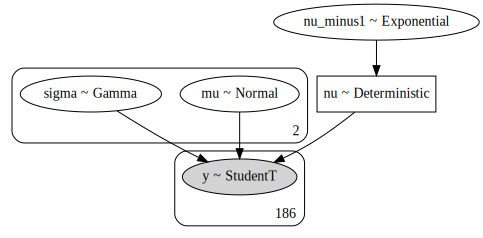

In [38]:
pm.model_to_graphviz(model_vd_theta)

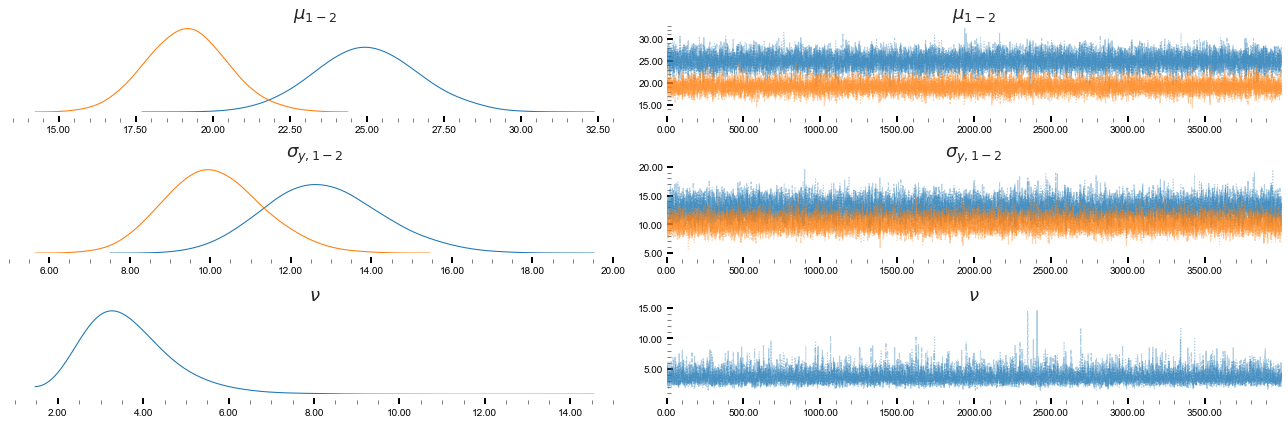

In [61]:
# my_traceplots(['mu', 'sigma', 'nu'], ['mu_{1-2}', 'sigma_{y, 1-2}', 'nu'], trace_vd_theta, "StudentTIndep")
my_traceplots(['mu', 'sigma', 'nu'], ["$\mu_{1-2}$", "$\sigma_{y, 1-2}$", r'$\nu$'], trace_vd_theta, "StudentTIndep")


In [40]:
az_vd_theta = az.from_pymc3(trace=trace_vd_theta)
vd_theta_summary = az.summary(az_vd_theta)
vd_theta_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],24.998,1.669,21.869,28.186,0.014,0.010,14259.0,14223.0,14270.0,12716.0,1.0
mu[1],19.169,1.311,16.669,21.606,0.011,0.007,15557.0,15411.0,15600.0,12795.0,1.0
sigma[0],12.823,1.447,10.220,15.621,0.013,0.010,11595.0,11595.0,11528.0,11739.0,1.0
sigma[1],10.092,1.197,7.886,12.344,0.011,0.008,11698.0,11698.0,11556.0,11921.0,1.0
nu_minus1,2.670,1.031,1.057,4.566,0.010,0.008,9764.0,9443.0,9716.0,11308.0,1.0
nu,3.670,1.031,2.057,5.566,0.010,0.007,9764.0,9518.0,9716.0,11308.0,1.0


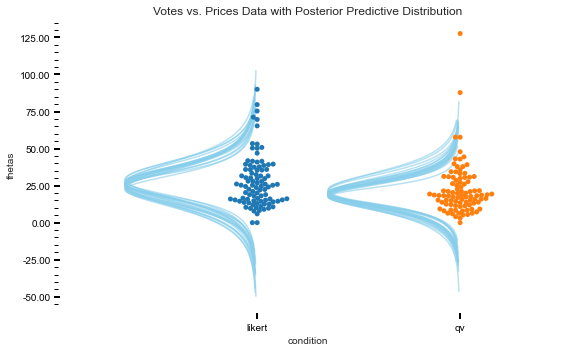

In [41]:
pred_posterior_plot(trace_vd_theta, all_vd_theta, 'Votes vs. Prices', color)

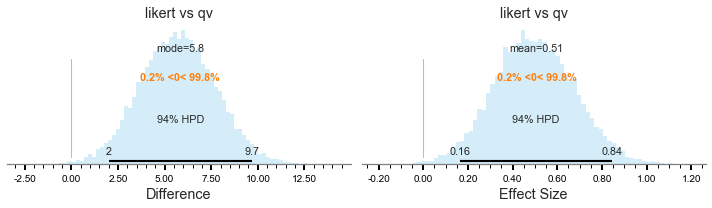

In [42]:
plot_effect_size_dist(trace_vd_theta, 'Votes vs. Prices', color)